In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
import config

sys.path.append("store_outputs/MNIST_7x7")
kernels = torch.load("store_outputs/MNIST_7x7/MNIST_8x7x7_kernels.pt")
sys.path.append("initial_phase")
from kernel_to_psf import Kernel2PSF

In [2]:
k2psf = Kernel2PSF(config)
raw_kernels = k2psf.split_kernels(kernels)
print("Kernels shape:", kernels.shape)
print("Raw kernels shape:", raw_kernels.shape)

Kernels shape: torch.Size([8, 1, 7, 7])
Raw kernels shape: torch.Size([16, 7, 7])


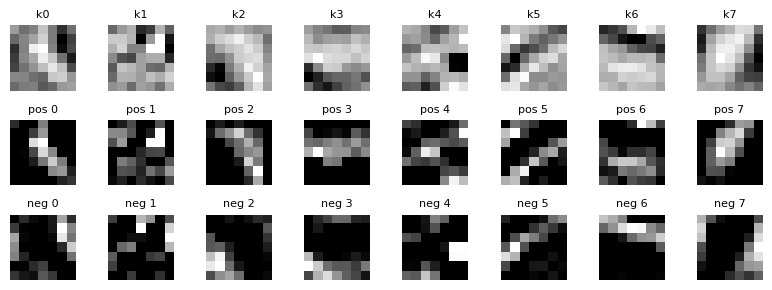

In [3]:
rk = raw_kernels  # (2K, H, W)
K = rk.shape[0] // 2
pos, neg = rk[0::2], rk[1::2]

cols = K
fig, ax = plt.subplots(3, cols, figsize=(cols, 3))

for i in range(K):
    ax[0, i].imshow(kernels[i].squeeze().cpu(), cmap="gray")
    ax[0, i].set_title(f"k{i}", fontsize=8)
    ax[0, i].axis("off")
for i in range(K):
    ax[1, i].imshow(pos[i].cpu(), cmap="gray")
    ax[1, i].set_title(f"pos {i}", fontsize=8)
    ax[1, i].axis("off")
for i in range(K):
    ax[2, i].imshow(neg[i].cpu(), cmap="gray")
    ax[2, i].set_title(f"neg {i}", fontsize=8)
    ax[2, i].axis("off")
    
plt.tight_layout()
plt.show()

Rearranged raw kernels shape: torch.Size([16, 7, 7])


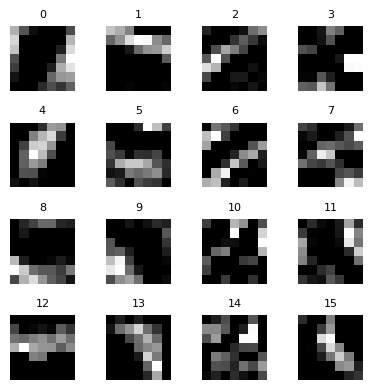

In [4]:
raw_kernels = k2psf.rearrange_kernels(raw_kernels, per_row=4)
print("Rearranged raw kernels shape:", raw_kernels.shape)

fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(16):
    ax.flat[i].imshow(raw_kernels[i].cpu(), cmap="gray")
    ax.flat[i].set_title(f"{i}", fontsize=8)
    ax.flat[i].axis("off")

plt.tight_layout()
plt.show()

Stitched image shape: torch.Size([255, 255])
Centers shape: torch.Size([16, 2])


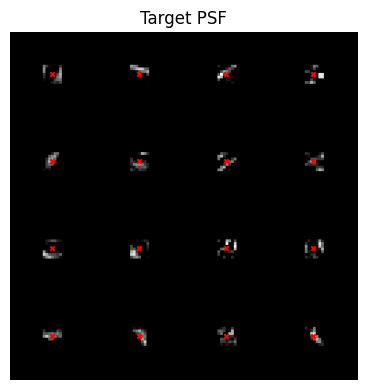

In [5]:
stitched, centers = k2psf.stitch_and_center(raw_kernels, upsample=2, per_row=4, gap=50, grid_N=255)
print("Stitched image shape:", stitched.shape)
print("Centers shape:", centers.shape)

plt.figure(figsize=(4,4))
plt.imshow(stitched.cpu(), cmap="gray")
plt.scatter(centers[:,1].cpu(), centers[:,0].cpu(), s=10, c="red", marker="x")
plt.title("Target PSF")
plt.axis("off")
plt.tight_layout()
plt.show()

Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


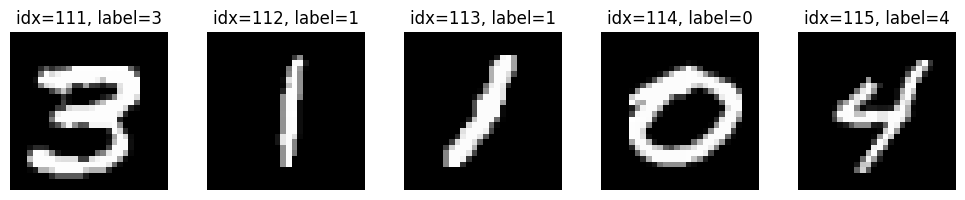

In [6]:
from torchvision.datasets import MNIST

N_batch, idx0, num_show = 10, 111, 5
ds = MNIST(root="./data", train=True, download=False)

pairs = [ds[idx0+i] for i in range(N_batch)]
objs = torch.stack([torch.from_numpy(np.array(x)).float()/255 for x,_ in pairs])
labels = [y for _,y in pairs]

print("Loaded batch:", objs.shape)
print("Labels (first 10):", labels[:10])

fig, ax = plt.subplots(1, num_show, figsize=(2*num_show,2))
for i in range(num_show):
    ax[i].imshow(objs[i], cmap="gray", vmin=0, vmax=1)
    ax[i].set_title(f"idx={idx0+i}, label={labels[i]}")
    ax[i].axis("off")
plt.tight_layout(); plt.show()

In [7]:
psf1 = stitched.T.flip(1).unsqueeze(0) 

asm = ASMPropagator(config)
pm = PixelMap(config, asm.X, asm.Y)
conv = PSFConv(config, pm, asm.X, asm.Y)
img = conv.sensor_image(objs[0], psf1) 

print("Sensor image shape:", img.shape)


Sensor image shape: torch.Size([1, 1, 255, 255])


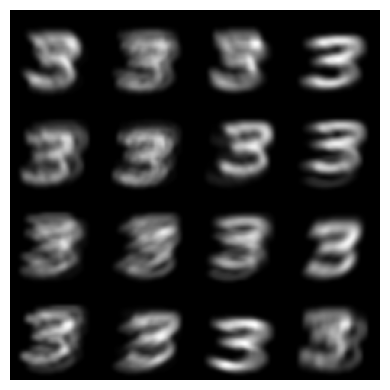

In [8]:
img2d = img[0, 0]

plt.figure(figsize=(4,4))
plt.imshow(img2d.cpu().T.flip(0).flip(1), cmap="gray", origin="lower")
plt.axis("off")
plt.tight_layout()
plt.show()


pos_out shape: torch.Size([8, 28, 28])


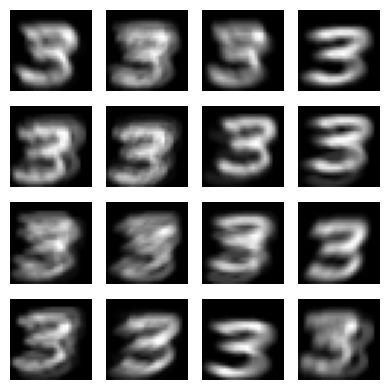

In [9]:
pos_out = F.conv2d(objs[0].unsqueeze(0).unsqueeze(0), pos.unsqueeze(1), padding="same")[0]  # (K,H,W)
neg_out = F.conv2d(objs[0].unsqueeze(0).unsqueeze(0), neg.unsqueeze(1), padding="same")[0]

print("pos_out shape:", pos_out.shape)

per_row = 4
K = pos.shape[0]
rows = (K + per_row - 1) // per_row * 2  # pos+neg per block

fig, ax = plt.subplots(rows, per_row, figsize=(per_row, rows))

r = 0
for start in range(0, K, per_row):
    end = min(start + per_row, K)
    n = end - start

    # pos row
    for c in range(per_row):
        a = ax[r, c]
        if c < n:
            a.imshow(pos_out[start + c].cpu(), cmap="gray")
        a.axis("off")
    r += 1

    # neg row
    for c in range(per_row):
        a = ax[r, c]
        if c < n:
            a.imshow(neg_out[start + c].cpu(), cmap="gray")
        a.axis("off")
    r += 1

plt.tight_layout()
plt.show()